In [267]:
import numpy as np
import tensorflow as tf
from scipy.stats import random_correlation
import matplotlib.pyplot as plt
from tqdm import tqdm

## Multidimensional Geometric Brownian Motion

In [230]:
T = 30 # time horizon
dt = 1/252 # discretisation
n = 10 # number of stocks
N = 1000 # sample size on simplex

NT = int(T/dt) # time
grid = np.linspace(0,T,NT+1) # time grid

S0 = 100*np.ones(n) # initial prices
mu = 0.07*np.ones(n) # drifts
sigma = 0.25*np.ones(n) # volas

eig = np.random.uniform(0.1, 1, n) # 
eig = eig/np.sum(eig)*n # Sum of eigenvalues must equal dimensionality.
rho = random_correlation.rvs(eig) # 
Cov = np.tensordot(sigma, sigma, 0) * rho

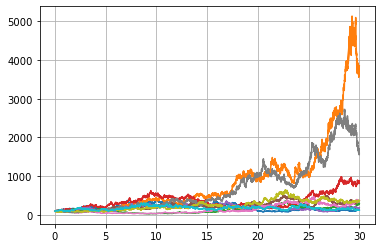

In [246]:
def GBMsimulator(seed, S0, mu, sigma, Cov, T, NT):
    if seed:
        np.random.seed(seed) 
    A = np.linalg.cholesky(Cov)
    dW = np.random.normal(size = (n,NT)) * np.sqrt(dt)
    S = np.zeros([n, NT+1])
    S[:, 0] = S0
    for i in range(NT):    
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = np.matmul(A, dW[:,i])
        S[:, i+1] = S[:, i]*np.exp(drift + diffusion)
    return S.T

S = GBMsimulator(None, S0, mu, sigma, Cov, T, NT)
plt.plot(grid,S)
plt.grid()

## Cover's Universal Portfolio 
is as good as the long run yield of the best retrospectively chosen constant rebalanced portfolio.

In [233]:
# normalized logarithmic return of each stocks
# R = S[-1]/S[0]
# nlr = np.log(R)/T
# plt.barh(np.arange(n)+1,nlr)
# plt.show()

In [258]:
S = GBMsimulator(None, S0, mu, sigma, Cov, T, NT)
R = S[-1]/S[0]

simplex_uniform = np.random.exponential(scale=1.0, size=[N,n])
simplex_uniform = simplex_uniform / np.sum(simplex_uniform,axis=-1,keepdims = True)

# equally weighted 
weight = np.ones(n)/n
V = (weight * R).sum()
print('equally weighted: ',V)

# best constant rebalanced portfolio strategies
V = np.sum(simplex_uniform * R, axis=-1)
print('best constant rebalanced: ',V.max())

#adaptive performance weighted strategy
def weight_update(S):
    weight_list = [np.ones(n)/n]
    weigth = weight_list[0]
    for i in range(NT):
        Rt = S[i+1]/S[i]
        Vt = np.sum(simplex_uniform * Rt, axis=-1)
        weight_new = np.mean(simplex_uniform*Vt[:,None],axis=0) / np.mean(Vt)
        weight_list.append(weight_new)
    return np.array(weight_list)
def wealth_update(weights):
    Vs = np.ones(NT+1)
    for i in range(NT):
        Rt = S[i+1]/S[i]
        Vs[i+1] = Vs[i] * (weights[i] * Rt).sum()
    return Vs

weights = weight_update(S)
Vs = wealth_update(weights)
print('adaptive rebalanced: ',Vs[-1])

equally weighted:  7.25148057957332
best constant rebalanced:  17.501576364023208
adaptive rebalanced:  7.649400604203385


In [287]:
def test(trials):
    Vconstant = np.zeros(trials)
    Vadapted = np.zeros(trials)
    for i in tqdm(range(trials)):
        S = GBMsimulator(None, S0, mu, sigma, Cov, T, NT)
        R = S[-1]/S[0]
        
        weight = np.ones(n)/n
        V = (weight * R).sum()
        Vconstant[i] = V
        
        V = np.sum(simplex_uniform * R, axis=-1)
        print('best constant rebalanced: ',V.max())
        
        weights = weight_update(S)
        Vs = wealth_update(weights)
        Vadapted[i] = Vs[-1]
        
    return Vconstant, Vadapted

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


In [295]:
Vconstant, Vadapted = test(100)

100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


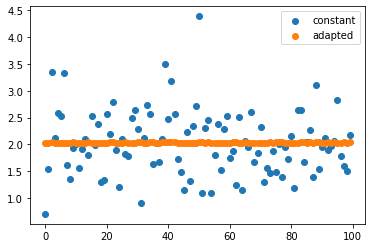

In [303]:
plt.scatter(np.arange(100),np.log(Vconstant),label = 'constant')
plt.scatter(np.arange(100),np.log(Vadapted),label = 'adapted')
plt.legend()

## Fernholz Stochastic Portfolio Theory
where rebalancing rule need not to be constant anymore but may depend on the present state of
the stock market

In [309]:
# market weights 
mu = S/np.sum(S,axis=1,keepdims = True)

## Log-optimal Numeraire Portfolio
not model-free but for comparision
